In [2]:
import os
import shutil
import time
import numpy as np
import pandas as pd
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from torch.utils.data import DataLoader,Subset
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn import model_selection 
from torchmetrics import F1Score
from torchmetrics.functional import precision
from torchmetrics.functional import recall
from torchmetrics.classification import MulticlassConfusionMatrix
import pickle

In [3]:
path = '/kaggle/input/cassava-leaf-disease-classification'
train_path = path + '/train_images/'

out_path = '/kaggle/working'
dataset_dir = out_path+'/dataset/'

# Data Preparation & Preprocessing

In [4]:
df = pd.read_csv(path+"/train.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [6]:
try:
    os.mkdir(dataset_dir)
    
    for folder in df.label.unique():
        os.mkdir(dataset_dir+str(folder))
except:
    print('Folder already exists')

Folder already exists


In [7]:
tpath = dataset_dir + os.listdir(dataset_dir)[0]

tic = time.time()

if len(os.listdir(tpath))== 0:
    for i in range(df.shape[0]):
        orig_path = train_path + str(df.iloc[i][0])
        new_path = dataset_dir + str(df.iloc[i][1])

        shutil.copy(orig_path, new_path)
    print("Time taken to move files: {} mins".format((time.time()-tic)/60))
else:
    print('files already moved')

files already moved


In [8]:
# CONSTANTS
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = len(df.label.unique())
NUM_FOLDS = 4 # for stratified k-fold
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
LOSS_FN = nn.CrossEntropyLoss()

In [9]:
# Resize images and normalize pixel values before passing it to the model
transformations = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ])

dataset = ImageFolder(dataset_dir, transform = transformations)

In [10]:
print('Total dataset',len(dataset))
CLASSES=''

with open(path+'/label_num_to_disease_map.json', 'r') as f:
    label_map = json.load(f)
    CLASSES = list(label_map.values())
    print('Classes')
    display(label_map)

Total dataset 21397
Classes


{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

Total train samples:  21397

Samples per class:
3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


<BarContainer object of 5 artists>

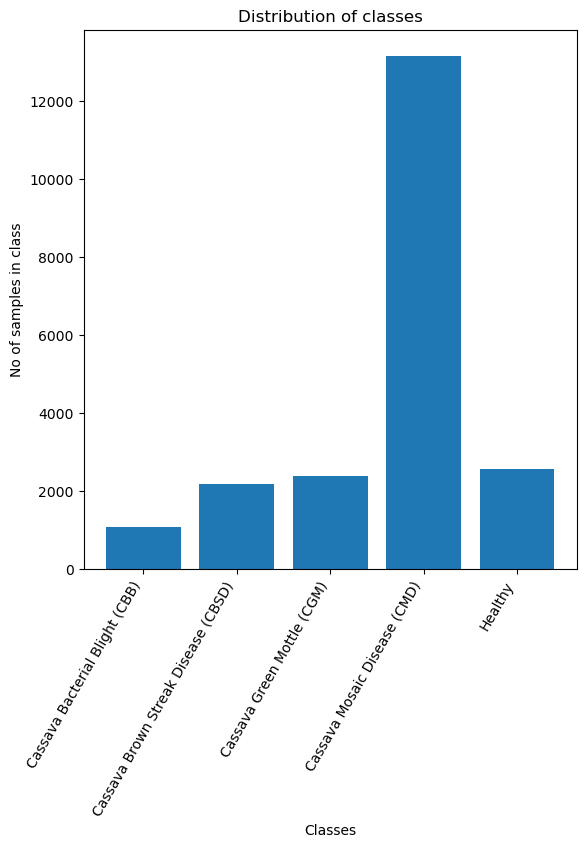

In [11]:
trs = len(os.listdir(train_path))
print("Total train samples: ",trs)

print("\nSamples per class:")
print(df.label.value_counts())

# Plot the distribution of classes in train and test sets
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60,  ha='right')

train_labels_dist = df.label.value_counts()
plt.bar(train_labels_dist.keys(), train_labels_dist)

In [16]:
def imshow(image):
    # utility method to print class label(s) and show image(s) of a row in the dataset
    
    if not isinstance(image,torch.Tensor):
        plt.figure(figsize=(4,4))
        print(f'Image sampled from class {image[1]} - "{label_map[str(image[1])]}"')
        
        npimg = np.array(image[0])
    else:
        plt.figure(figsize=(14,7))
        npimg = image.numpy()
        
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Unnormalized Images:

Image sampled from class 0 - "Cassava Bacterial Blight (CBB)"


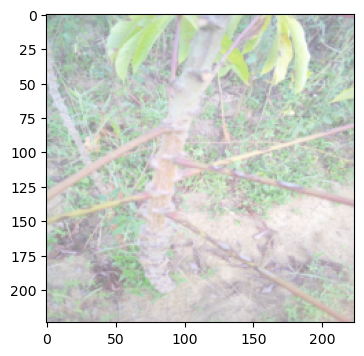

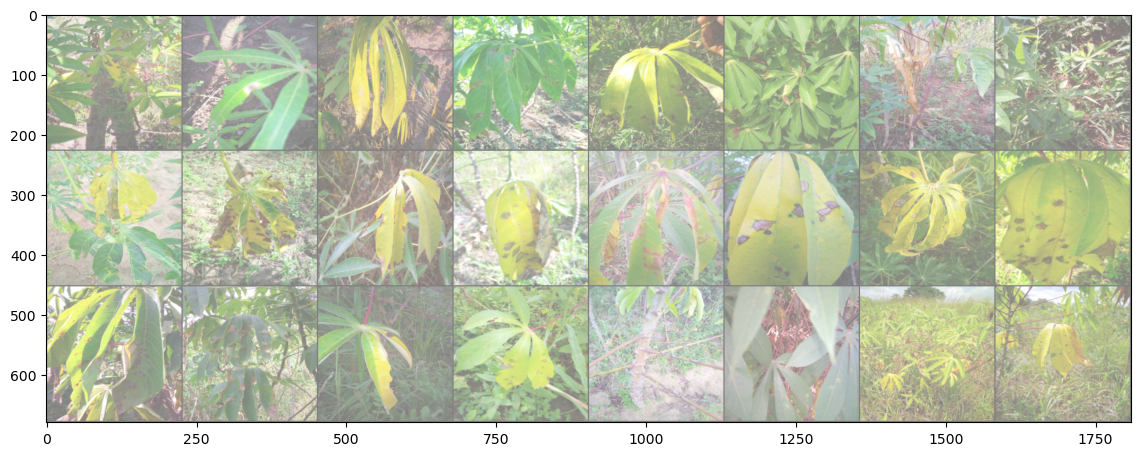

In [21]:
transformations_temp = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      transforms.ToTensor(),
                                     ])

dataset_unnormalized = ImageFolder(dataset_dir, transform = transformations_temp)

print('Unnormalized Images:\n')
imshow(dataset_unnormalized[20])
imshow(make_grid([dataset_unnormalized[idx][0] for idx in range(24)]))

Normalized Images:
Image sampled from class 0 - "Cassava Bacterial Blight (CBB)"


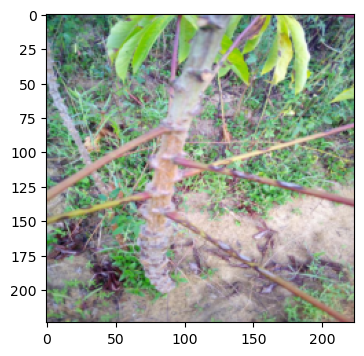

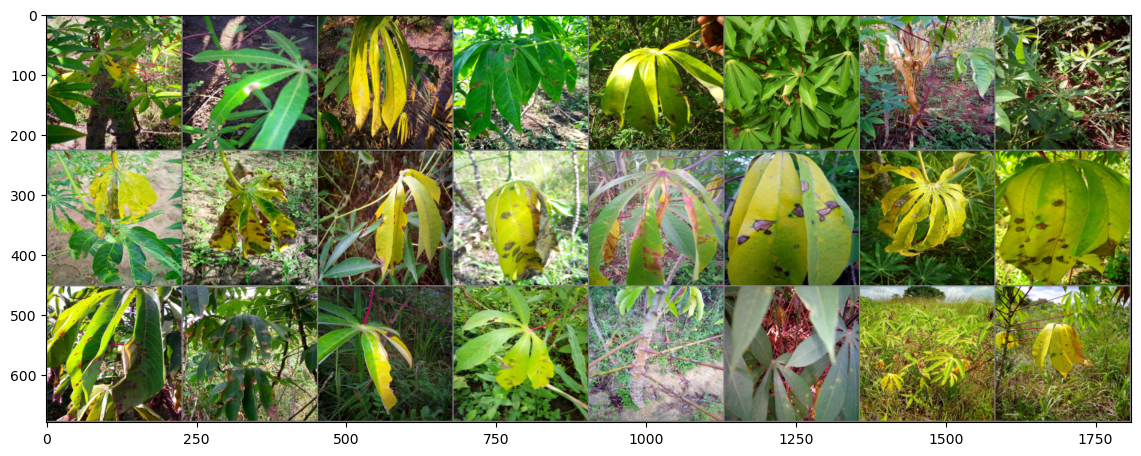

In [22]:
print("Normalized Images:")
imshow(dataset[20])
imshow(make_grid([dataset[idx][0] for idx in range(24)]))

In [13]:
all_idxs = np.arange(len(dataset))

# perform a 70/30 train-test stratified split
train_idxs, test_idxs = model_selection.train_test_split(all_idxs, test_size=0.3,
                                         stratify=dataset.targets,
                                         random_state=0)

# get the train and test set targets/labels
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]

# set the test set's dataloader
testset_loader = torch.utils.data.DataLoader(Subset(dataset, test_idxs),
                                             batch_size=BATCH_SIZE, 
                                             shuffle=True,
                                             drop_last=True)

print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 14977
test dataset 6420


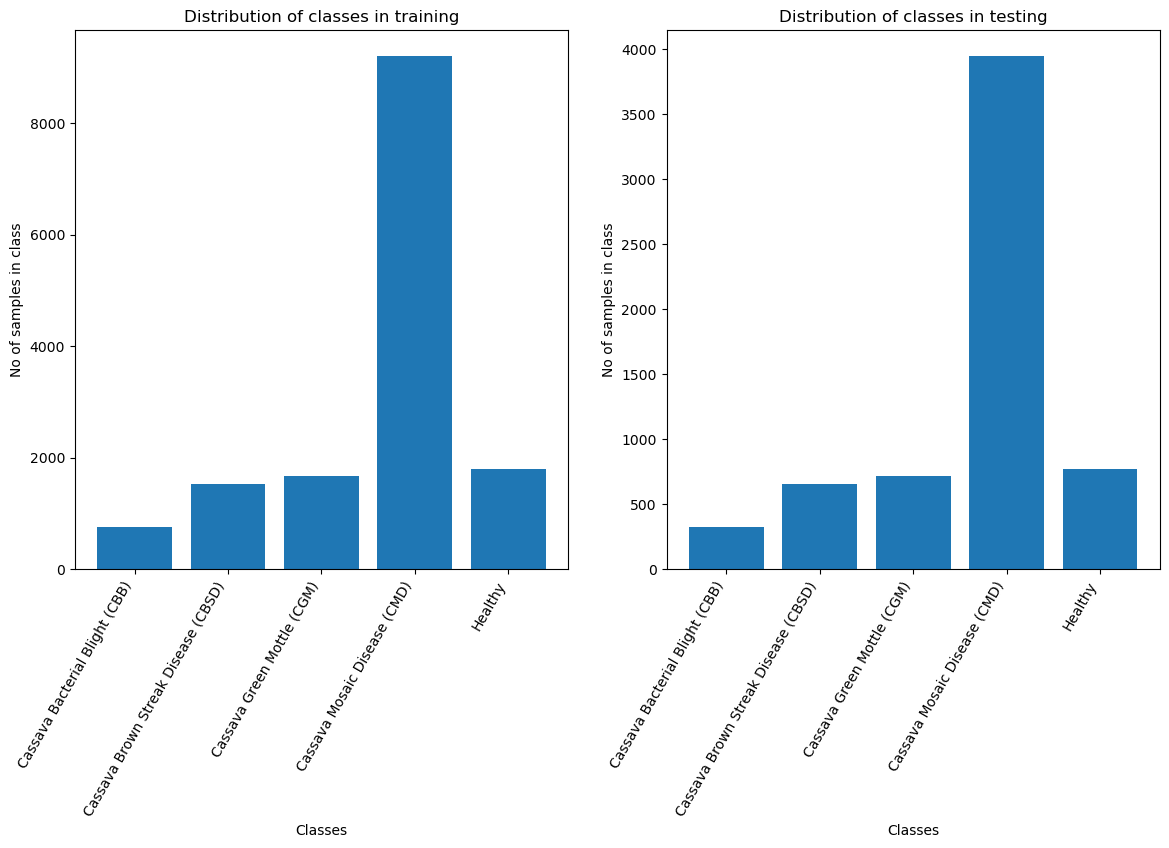

In [14]:
# Plot the distribution of classes in train and test sets
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60,  ha='right')

train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())
# train_df.label.value_counts().plot(kind="bar")

plt.subplot(1,2,2)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60,  ha='right')

test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());
# test_df.label.value_counts().plot(kind="bar")

# Model Definitions

#### Custom CNN

In [21]:
# 1. A rather shallow CNN to classify
class CustomCNN(nn.Module):
    def __init__(self, kernel_size=5, padding=1):
        super(CustomCNN, self).__init__()

        # convolutional block #1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional block #2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # dense linear layer with ReLU activation
        self.fc = nn.Sequential(
            nn.Linear(93312, 8*8*8),
            nn.ReLU(inplace=True),
            nn.Linear(8*8*8, NUM_CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### ResNet-50

In [15]:
def get_ResNet_model():

    ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50',
                                 weights='ResNet50_Weights.DEFAULT')
    
    # layers = ResNet_model.state_dict().keys()

    for name, param in ResNet_model.named_parameters():
        if not name.startswith('fc'):
            param.requires_grad = False
    
    prev_out = ResNet_model.fc.in_features
    ResNet_model.fc = nn.Linear( prev_out, NUM_CLASSES)
    
    return ResNet_model

In [16]:
# for name, param in ResNet_model.named_parameters():
#         print("Layer: {} has requires_grad set to: {}".format(name, param.requires_grad))

In [17]:
# ResNet_model.eval()

#### VGG-16-BN

In [18]:
def get_VGG_model():

    VGG_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', 
                                weights='VGG16_BN_Weights.DEFAULT')

    for name, param in VGG_model.named_parameters():
        if not name.startswith('classifier.6'):
            param.requires_grad = False
    
    prev_out = VGG_model.classifier[6].in_features
    VGG_model.classifier[6] = nn.Linear( prev_out, NUM_CLASSES)
    
    return VGG_model

# Training Helper functions

In [19]:
def train_model(k_fold_num, model, train_loader, optimizer, device):

    epoch_metrics = []

    total_steps = len(train_loader)

    t1 = time.time()

    for epoch in range(NUM_EPOCHS):
        for i, data in enumerate(train_loader):

            images, labels = data[0].to(device), data[1].to(device)

            model.train()

            # Forward pass
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()


            train_loss = loss.item()
            train_acc = (correct / total) * 100

            epoch_metrics.append({'fold':k_fold_num,'epoch':epoch + (i/total_steps),'loss':train_loss, 'accuracy':train_acc})

            if i % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                          .format(epoch + 1, NUM_EPOCHS, i + 1, total_steps, train_loss,
                              train_acc))

    print("######## Training for fold {} Finished in {:.4f} seconds ###########".format(k_fold_num+1, time.time()-t1))                  
    
    savepath = f'{model.__class__.__name__}-model.pt'
    print("/n/n Saving model at: ",savepath)
    torch.save(model.state_dict(), savepath)
    print()

    return epoch_metrics, device

In [20]:
def start_training(model, device):
    
    total_scores = []
    total_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))
    
    # a stratified k-fold splitter instance with NUM_FOLDS
    kf = model_selection.StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)
    
    epoch_metrics_df = pd.DataFrame(columns=['fold','epoch','loss','accuracy'])
    
    # iterate over each fold
    for k_fold_num, (train_index, test_index) in enumerate(kf.split(train_idxs,train_labels)):
        
        model.to(device)
        
        print('Running K-Fold cross-validation on fold-', k_fold_num+1)
        
        train_fold = Subset(dataset, train_idxs[train_index])
        test_fold = Subset(dataset, train_idxs[test_index])

        train_loader = torch.utils.data.DataLoader(train_fold, 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, 
                                                  drop_last=True)
        
        test_loader = torch.utils.data.DataLoader(test_fold, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=True, 
                                                 drop_last=True)

        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

        # run training
        epoch_metrics, device = train_model(k_fold_num, model, train_loader, optimizer, device)
        epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)
        
        # run evaluation on validation fold 
        conf_matrix, scores = evaluate_model(model, test_loader, device, NUM_CLASSES)

        total_scores.append(scores)
        total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)
        
        # reset model parameters when going to the next fold
        if k_fold_num != NUM_FOLDS-1:
            if model.__class__.__name__ == 'ResNet':
                model = get_ResNet_model()
            if model.__class__.__name__ == 'VGG':
                model = get_VGG_model()
            if model.__class__.__name__ == 'CustomCNN':
                model = model.__class__()
            
    scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])

    return scores_df, epoch_metrics_df, total_confusion_matrix, device

In [21]:
def evaluate_model(model, test_loader, device, nclasses):
   
    model.eval() 

    Y=[]
    y=[]

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            Y.extend(labels)
            y.extend(predicted)

        acc = (correct / total) * 100
        f1 = F1Score(task="multiclass", num_classes=nclasses, average='macro')
        f1score = f1(torch.IntTensor(y),torch.IntTensor(Y))
        pr = precision(torch.IntTensor(y),torch.IntTensor(Y),task="multiclass", average='macro', num_classes=nclasses)
        re = recall(torch.IntTensor(y),torch.IntTensor(Y),task="multiclass", average='macro', num_classes=nclasses)
        cf = MulticlassConfusionMatrix(num_classes=nclasses)
        conf_matrix = cf(torch.IntTensor(y),torch.IntTensor(Y))
        
        return conf_matrix,[acc, f1score, pr, re]

def pretty_print_metrics(metrics):
    print('-- TEST SET METRICS --')
    print(f'Accuracy: {metrics[0]:.3f}%\nF-score: {metrics[1]:.3f}\nRecall: {metrics[2]:.3f}\nPrecision: {metrics[3]:.3f}')

In [22]:
def test_model(model, device, test_loader ):
    
    savepath = f'{model.__class__.__name__}-model.pt'
    model.load_state_dict(torch.load(savepath))
    
    model.to(device)
    
    conf_mat, metrics = evaluate_model(model, test_loader, device, NUM_CLASSES)
    pretty_print_metrics(metrics)
    plot_cm(np.array(conf_mat), CLASSES)

# Plotting Utilities

In [23]:
# Utility method to plot both accuracy vs num epochs and loss vs num epochs
def plot_training_metrics(training_metrics_df):
    fig, ax = plt.subplots(2, figsize=(20,10))

    ax[0].set_xlabel('Number of epochs')
    ax[1].set_xlabel('Number of epochs')
    ax[0].set_ylabel('Training accuracy %')
    ax[1].set_ylabel('Training loss')
    
    for _fold in range(0, NUM_FOLDS):
        temp_df = training_metrics_df.query('fold == @_fold')
        if _fold == 0:
            ax[0].set_title('Training Accuracy vs Number of Epochs')
            ax[1].set_title('Training Loss vs Number of Epochs')
        ax[0].plot(temp_df.epoch.values, temp_df.accuracy.values, label=f'fold-{_fold+1} accuracy')
        ax[1].plot(temp_df.epoch.values, temp_df.loss.values, label=f'fold-{_fold+1} loss')

    ax[0].legend()
    ax[1].legend()

In [24]:
# Utility method to plot the confusion matrix over k-folds
def plot_cm(cm, classes, cmap=plt.cm.Reds):
    
    title = 'Confusion Matrix'
    
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')


# Model Training

In [25]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Using ResNet-50

In [26]:
ResNet_model = get_ResNet_model()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
scores_df, epoch_metrics_df, \
total_confusion_matrix, device = start_training(ResNet_model , device)

Running K-Fold cross-validation on fold- 1
Epoch [1/5], Step [1/87], Loss: 1.5691, Accuracy: 36.72%
Epoch [1/5], Step [31/87], Loss: 0.9470, Accuracy: 63.28%
Epoch [1/5], Step [61/87], Loss: 0.8787, Accuracy: 70.31%
Epoch [2/5], Step [1/87], Loss: 1.0349, Accuracy: 57.03%
Epoch [2/5], Step [31/87], Loss: 0.8699, Accuracy: 69.53%
Epoch [2/5], Step [61/87], Loss: 0.8122, Accuracy: 61.72%
Epoch [3/5], Step [1/87], Loss: 0.5784, Accuracy: 81.25%
Epoch [3/5], Step [31/87], Loss: 0.7276, Accuracy: 73.44%
Epoch [3/5], Step [61/87], Loss: 0.6729, Accuracy: 74.22%
Epoch [4/5], Step [1/87], Loss: 0.7041, Accuracy: 75.00%
Epoch [4/5], Step [31/87], Loss: 0.7210, Accuracy: 73.44%
Epoch [4/5], Step [61/87], Loss: 0.6789, Accuracy: 78.12%
Epoch [5/5], Step [1/87], Loss: 0.5619, Accuracy: 82.81%
Epoch [5/5], Step [31/87], Loss: 0.5930, Accuracy: 80.47%
Epoch [5/5], Step [61/87], Loss: 0.5258, Accuracy: 79.69%
######## Training for fold 1 Finished in 827.7934 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 2
Epoch [1/5], Step [1/87], Loss: 1.5912, Accuracy: 24.22%
Epoch [1/5], Step [31/87], Loss: 0.9999, Accuracy: 60.16%
Epoch [1/5], Step [61/87], Loss: 0.9547, Accuracy: 67.19%
Epoch [2/5], Step [1/87], Loss: 0.7229, Accuracy: 74.22%
Epoch [2/5], Step [31/87], Loss: 0.8596, Accuracy: 66.41%
Epoch [2/5], Step [61/87], Loss: 0.7231, Accuracy: 73.44%
Epoch [3/5], Step [1/87], Loss: 0.7631, Accuracy: 75.78%
Epoch [3/5], Step [31/87], Loss: 0.6909, Accuracy: 76.56%
Epoch [3/5], Step [61/87], Loss: 0.8390, Accuracy: 70.31%
Epoch [4/5], Step [1/87], Loss: 0.6113, Accuracy: 78.91%
Epoch [4/5], Step [31/87], Loss: 0.7826, Accuracy: 75.78%
Epoch [4/5], Step [61/87], Loss: 0.7284, Accuracy: 71.88%
Epoch [5/5], Step [1/87], Loss: 0.6594, Accuracy: 72.66%
Epoch [5/5], Step [31/87], Loss: 0.5793, Accuracy: 77.34%
Epoch [5/5], Step [61/87], Loss: 0.6592, Accuracy: 76.56%
######## Training for fold 2 Finished in 819.4276 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 3
Epoch [1/5], Step [1/87], Loss: 1.6222, Accuracy: 18.75%
Epoch [1/5], Step [31/87], Loss: 1.0796, Accuracy: 60.16%
Epoch [1/5], Step [61/87], Loss: 0.9464, Accuracy: 65.62%
Epoch [2/5], Step [1/87], Loss: 0.8029, Accuracy: 70.31%
Epoch [2/5], Step [31/87], Loss: 0.7708, Accuracy: 73.44%
Epoch [2/5], Step [61/87], Loss: 0.7380, Accuracy: 75.00%
Epoch [3/5], Step [1/87], Loss: 0.7621, Accuracy: 69.53%
Epoch [3/5], Step [31/87], Loss: 0.6676, Accuracy: 78.12%
Epoch [3/5], Step [61/87], Loss: 0.6867, Accuracy: 74.22%
Epoch [4/5], Step [1/87], Loss: 0.6865, Accuracy: 77.34%
Epoch [4/5], Step [31/87], Loss: 0.7449, Accuracy: 69.53%
Epoch [4/5], Step [61/87], Loss: 0.6608, Accuracy: 77.34%
Epoch [5/5], Step [1/87], Loss: 0.6136, Accuracy: 82.03%
Epoch [5/5], Step [31/87], Loss: 0.7270, Accuracy: 73.44%
Epoch [5/5], Step [61/87], Loss: 0.5945, Accuracy: 79.69%
######## Training for fold 3 Finished in 816.7746 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 4
Epoch [1/5], Step [1/87], Loss: 1.5912, Accuracy: 21.09%
Epoch [1/5], Step [31/87], Loss: 0.9654, Accuracy: 65.62%
Epoch [1/5], Step [61/87], Loss: 0.9502, Accuracy: 66.41%
Epoch [2/5], Step [1/87], Loss: 0.7445, Accuracy: 75.78%
Epoch [2/5], Step [31/87], Loss: 0.8796, Accuracy: 63.28%
Epoch [2/5], Step [61/87], Loss: 0.6739, Accuracy: 74.22%
Epoch [3/5], Step [1/87], Loss: 0.7665, Accuracy: 75.00%
Epoch [3/5], Step [31/87], Loss: 0.7539, Accuracy: 77.34%
Epoch [3/5], Step [61/87], Loss: 0.7506, Accuracy: 64.84%
Epoch [4/5], Step [1/87], Loss: 0.6578, Accuracy: 75.00%
Epoch [4/5], Step [31/87], Loss: 0.6387, Accuracy: 78.12%
Epoch [4/5], Step [61/87], Loss: 0.7030, Accuracy: 77.34%
Epoch [5/5], Step [1/87], Loss: 0.5811, Accuracy: 79.69%
Epoch [5/5], Step [31/87], Loss: 0.7417, Accuracy: 76.56%
Epoch [5/5], Step [61/87], Loss: 0.6422, Accuracy: 75.78%
######## Training for fold 4 Finished in 813.4243 seconds ###########
/n/n Saving model at: 

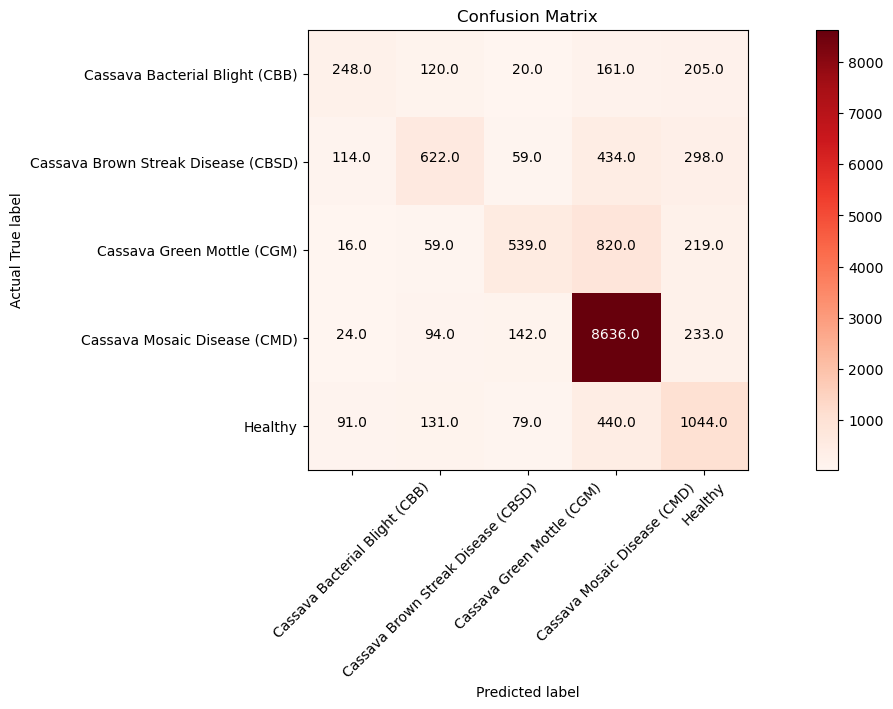

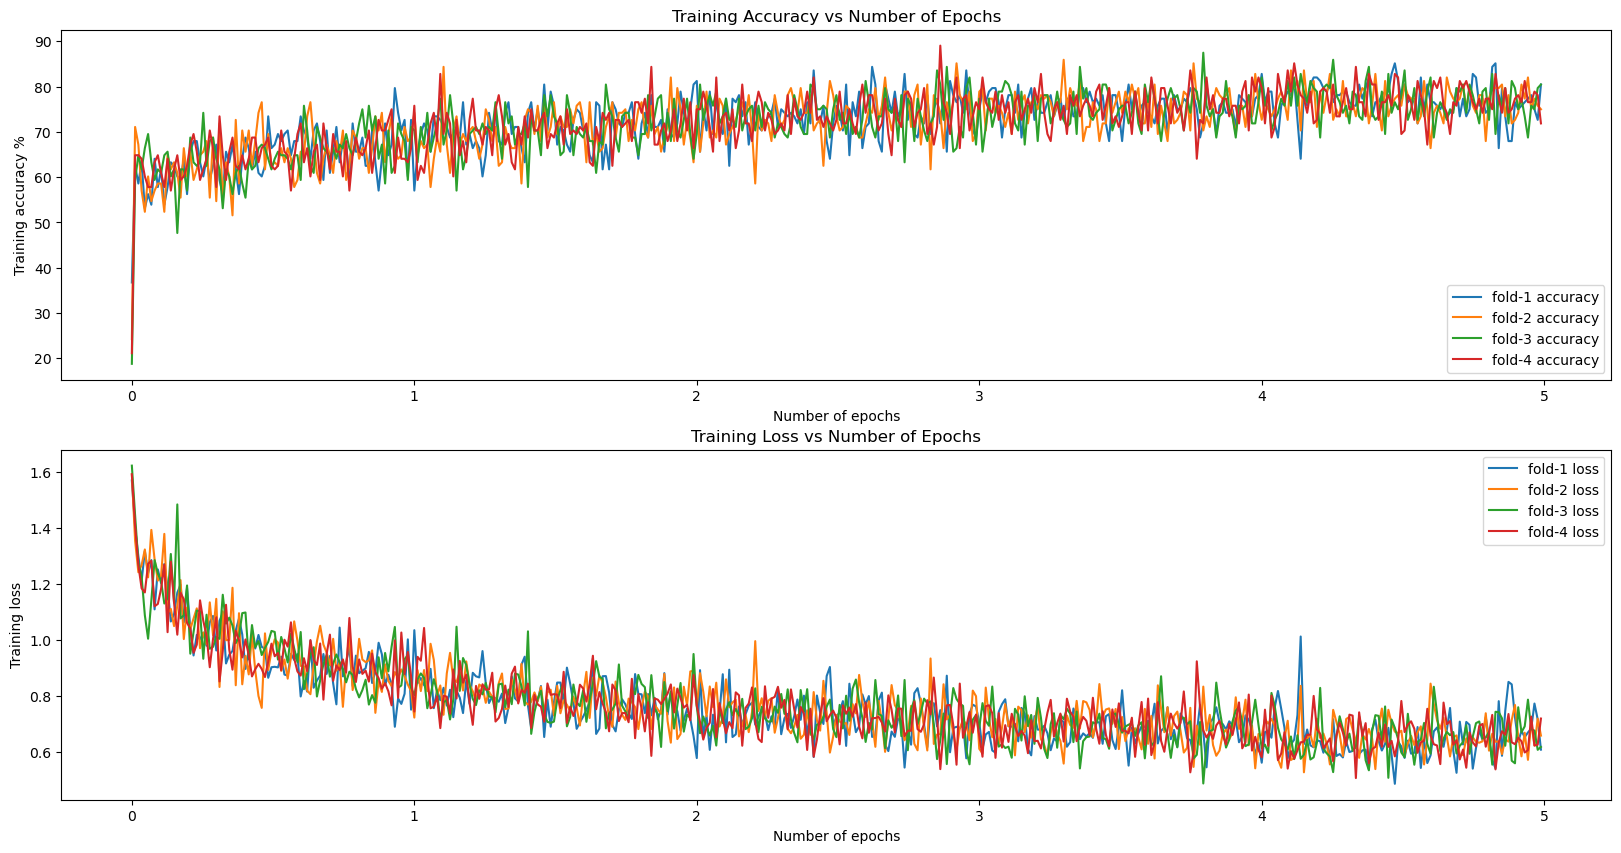

In [28]:
# plot the confusion matrix and the training metrics
conf_mat = np.array(total_confusion_matrix)

plot_cm(conf_mat, CLASSES)
plot_training_metrics(epoch_metrics_df)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


-- TEST SET METRICS --
Accuracy: 74.750%
F-score: 0.540
Recall: 0.628
Precision: 0.509


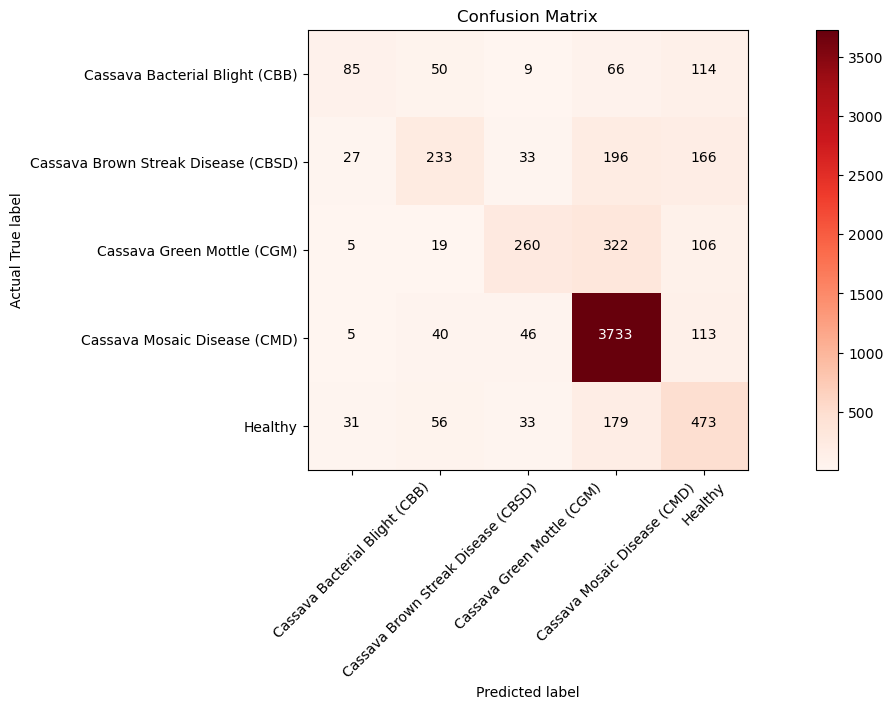

In [29]:
test_model(get_ResNet_model(), device, testset_loader )

#### Using VGG-16-BN

In [30]:
VGG_model = get_VGG_model()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [31]:
scores_df, epoch_metrics_df, \
total_confusion_matrix, device = start_training(VGG_model , device)

Running K-Fold cross-validation on fold- 1
Epoch [1/5], Step [1/87], Loss: 1.5690, Accuracy: 24.22%
Epoch [1/5], Step [31/87], Loss: 0.9068, Accuracy: 65.62%
Epoch [1/5], Step [61/87], Loss: 0.8572, Accuracy: 69.53%
Epoch [2/5], Step [1/87], Loss: 0.7803, Accuracy: 71.09%
Epoch [2/5], Step [31/87], Loss: 0.7262, Accuracy: 75.00%
Epoch [2/5], Step [61/87], Loss: 0.6954, Accuracy: 74.22%
Epoch [3/5], Step [1/87], Loss: 0.6504, Accuracy: 78.91%
Epoch [3/5], Step [31/87], Loss: 0.8565, Accuracy: 68.75%
Epoch [3/5], Step [61/87], Loss: 0.7218, Accuracy: 70.31%
Epoch [4/5], Step [1/87], Loss: 0.7775, Accuracy: 71.88%
Epoch [4/5], Step [31/87], Loss: 0.6717, Accuracy: 75.00%
Epoch [4/5], Step [61/87], Loss: 0.8302, Accuracy: 69.53%
Epoch [5/5], Step [1/87], Loss: 0.8194, Accuracy: 65.62%
Epoch [5/5], Step [31/87], Loss: 0.7042, Accuracy: 71.09%
Epoch [5/5], Step [61/87], Loss: 0.7642, Accuracy: 69.53%
######## Training for fold 1 Finished in 951.8870 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 2
Epoch [1/5], Step [1/87], Loss: 1.6574, Accuracy: 14.06%
Epoch [1/5], Step [31/87], Loss: 0.8519, Accuracy: 67.19%
Epoch [1/5], Step [61/87], Loss: 0.8028, Accuracy: 69.53%
Epoch [2/5], Step [1/87], Loss: 0.7416, Accuracy: 73.44%
Epoch [2/5], Step [31/87], Loss: 0.7188, Accuracy: 74.22%
Epoch [2/5], Step [61/87], Loss: 0.8328, Accuracy: 68.75%
Epoch [3/5], Step [1/87], Loss: 0.8489, Accuracy: 66.41%
Epoch [3/5], Step [31/87], Loss: 0.8313, Accuracy: 70.31%
Epoch [3/5], Step [61/87], Loss: 0.7104, Accuracy: 70.31%
Epoch [4/5], Step [1/87], Loss: 0.7569, Accuracy: 68.75%
Epoch [4/5], Step [31/87], Loss: 0.7452, Accuracy: 71.09%
Epoch [4/5], Step [61/87], Loss: 0.6570, Accuracy: 78.12%
Epoch [5/5], Step [1/87], Loss: 0.7018, Accuracy: 67.97%
Epoch [5/5], Step [31/87], Loss: 0.8066, Accuracy: 67.97%
Epoch [5/5], Step [61/87], Loss: 0.7649, Accuracy: 73.44%
######## Training for fold 2 Finished in 952.1087 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 3
Epoch [1/5], Step [1/87], Loss: 1.6688, Accuracy: 16.41%
Epoch [1/5], Step [31/87], Loss: 0.7734, Accuracy: 71.09%
Epoch [1/5], Step [61/87], Loss: 0.8792, Accuracy: 68.75%
Epoch [2/5], Step [1/87], Loss: 0.8023, Accuracy: 69.53%
Epoch [2/5], Step [31/87], Loss: 0.8329, Accuracy: 66.41%
Epoch [2/5], Step [61/87], Loss: 0.7805, Accuracy: 76.56%
Epoch [3/5], Step [1/87], Loss: 0.8591, Accuracy: 67.19%
Epoch [3/5], Step [31/87], Loss: 0.7438, Accuracy: 68.75%
Epoch [3/5], Step [61/87], Loss: 0.6549, Accuracy: 77.34%
Epoch [4/5], Step [1/87], Loss: 0.8896, Accuracy: 66.41%
Epoch [4/5], Step [31/87], Loss: 0.6008, Accuracy: 86.72%
Epoch [4/5], Step [61/87], Loss: 0.7395, Accuracy: 69.53%
Epoch [5/5], Step [1/87], Loss: 0.6108, Accuracy: 74.22%
Epoch [5/5], Step [31/87], Loss: 0.7547, Accuracy: 75.78%
Epoch [5/5], Step [61/87], Loss: 0.7102, Accuracy: 75.78%
######## Training for fold 3 Finished in 946.4303 seconds ###########
/n/n Saving model at: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Running K-Fold cross-validation on fold- 4
Epoch [1/5], Step [1/87], Loss: 1.6905, Accuracy: 14.06%
Epoch [1/5], Step [31/87], Loss: 0.8087, Accuracy: 71.88%
Epoch [1/5], Step [61/87], Loss: 0.9182, Accuracy: 63.28%
Epoch [2/5], Step [1/87], Loss: 0.5658, Accuracy: 78.91%
Epoch [2/5], Step [31/87], Loss: 0.6201, Accuracy: 75.00%
Epoch [2/5], Step [61/87], Loss: 0.6432, Accuracy: 79.69%
Epoch [3/5], Step [1/87], Loss: 0.6409, Accuracy: 76.56%
Epoch [3/5], Step [31/87], Loss: 0.8086, Accuracy: 68.75%
Epoch [3/5], Step [61/87], Loss: 0.8061, Accuracy: 72.66%
Epoch [4/5], Step [1/87], Loss: 0.7458, Accuracy: 75.00%
Epoch [4/5], Step [31/87], Loss: 0.7905, Accuracy: 69.53%
Epoch [4/5], Step [61/87], Loss: 0.6520, Accuracy: 76.56%
Epoch [5/5], Step [1/87], Loss: 0.7457, Accuracy: 67.97%
Epoch [5/5], Step [31/87], Loss: 0.7548, Accuracy: 71.09%
Epoch [5/5], Step [61/87], Loss: 0.8214, Accuracy: 71.88%
######## Training for fold 4 Finished in 941.5170 seconds ###########
/n/n Saving model at: 

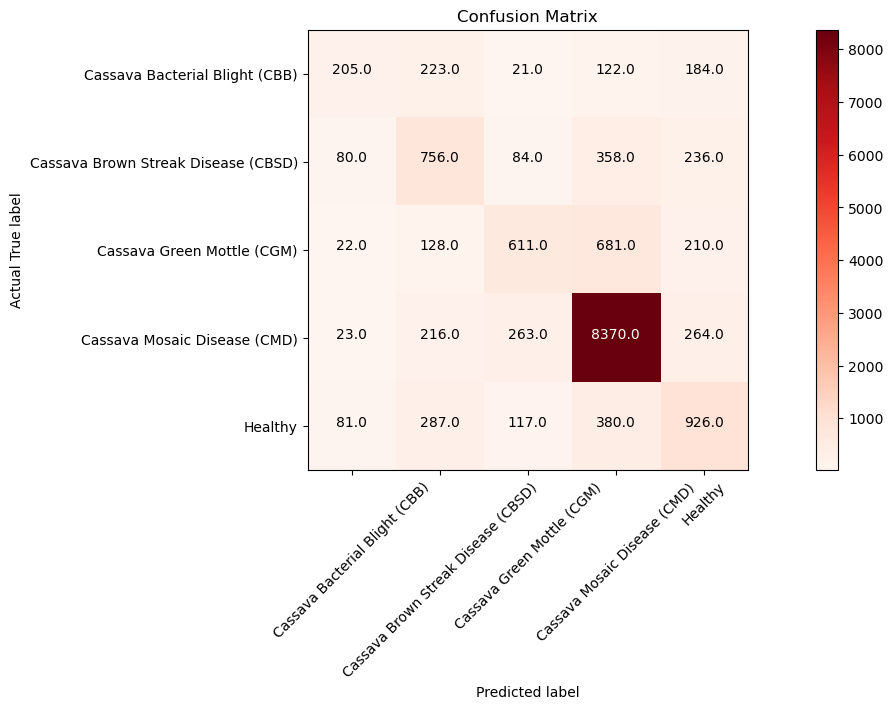

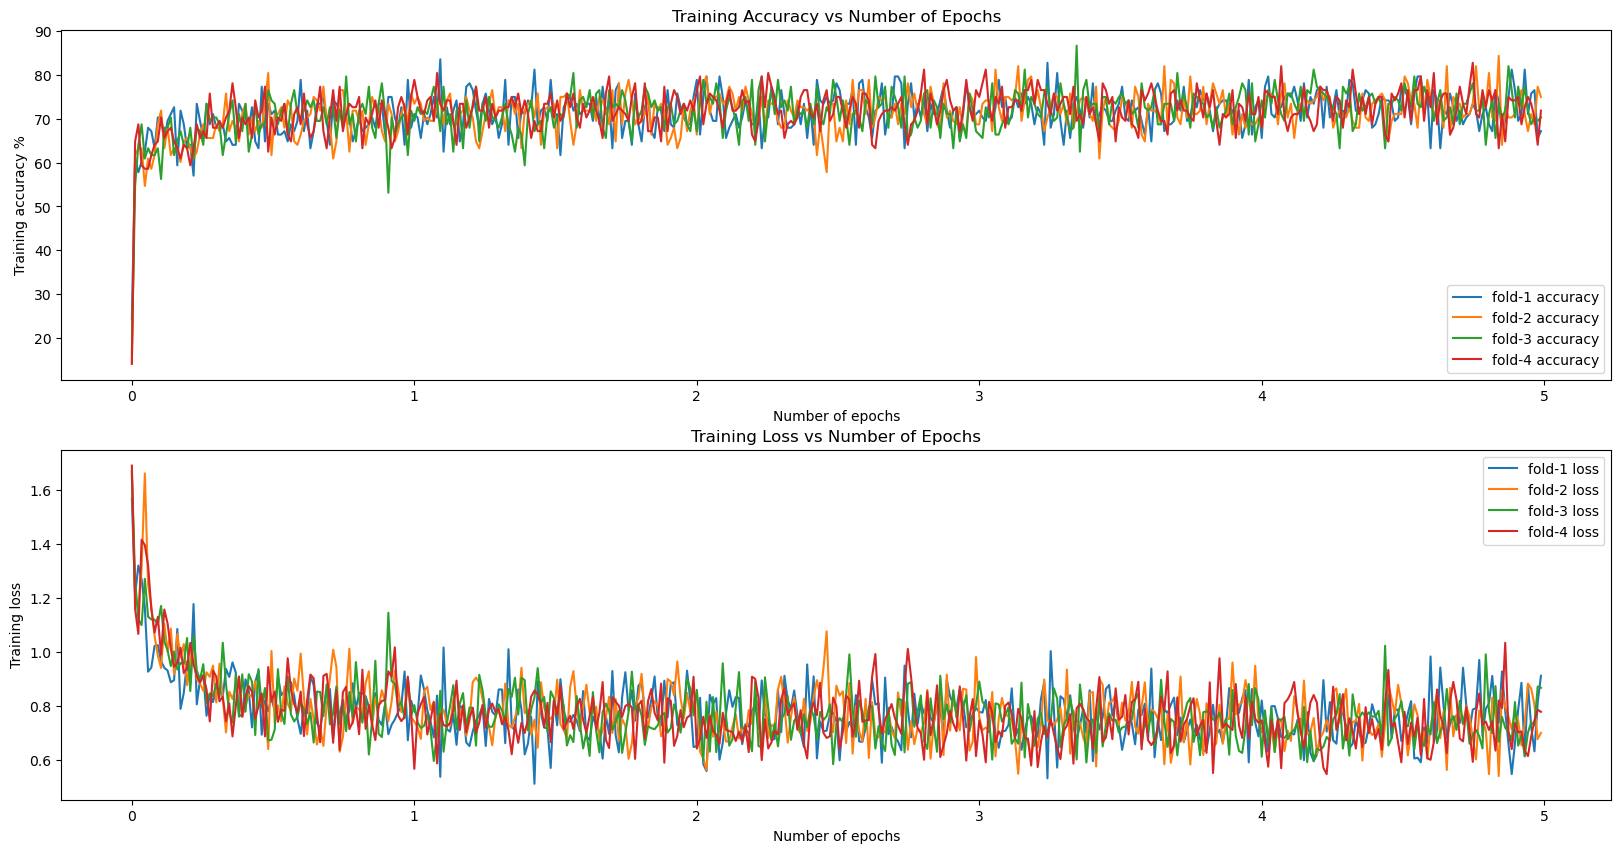

In [32]:
# plot the confusion matrix and the training metrics
conf_mat = np.array(total_confusion_matrix)

plot_cm(conf_mat, CLASSES)
plot_training_metrics(epoch_metrics_df)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


-- TEST SET METRICS --
Accuracy: 73.609%
F-score: 0.522
Recall: 0.592
Precision: 0.500


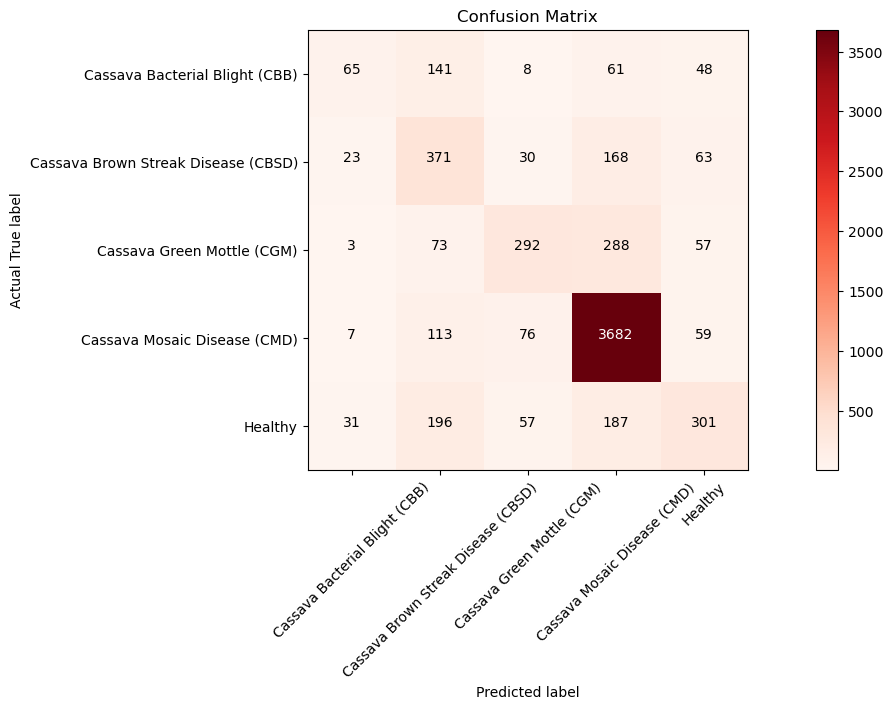

In [33]:
test_model(get_VGG_model(), device, testset_loader )

#### Using Custom CNN

In [22]:
scores_df, epoch_metrics_df, \
total_confusion_matrix, device = start_training(CustomCNN() , device)

Running K-Fold cross-validation on fold- 1
Epoch [1/5], Step [1/87], Loss: 1.5910, Accuracy: 17.97%
Epoch [1/5], Step [31/87], Loss: 1.1562, Accuracy: 61.72%
Epoch [1/5], Step [61/87], Loss: 1.1353, Accuracy: 60.94%
Epoch [2/5], Step [1/87], Loss: 1.1106, Accuracy: 60.94%
Epoch [2/5], Step [31/87], Loss: 1.1634, Accuracy: 58.59%
Epoch [2/5], Step [61/87], Loss: 1.2135, Accuracy: 55.47%
Epoch [3/5], Step [1/87], Loss: 0.9573, Accuracy: 67.19%
Epoch [3/5], Step [31/87], Loss: 1.0667, Accuracy: 60.16%
Epoch [3/5], Step [61/87], Loss: 1.1011, Accuracy: 56.25%
Epoch [4/5], Step [1/87], Loss: 1.0161, Accuracy: 61.72%
Epoch [4/5], Step [31/87], Loss: 1.0597, Accuracy: 60.16%
Epoch [4/5], Step [61/87], Loss: 1.0110, Accuracy: 60.94%
Epoch [5/5], Step [1/87], Loss: 0.8396, Accuracy: 67.19%
Epoch [5/5], Step [31/87], Loss: 1.0036, Accuracy: 60.16%
Epoch [5/5], Step [61/87], Loss: 0.8576, Accuracy: 66.41%
######## Training for fold 1 Finished in 757.8810 seconds ###########
/n/n Saving model at: 

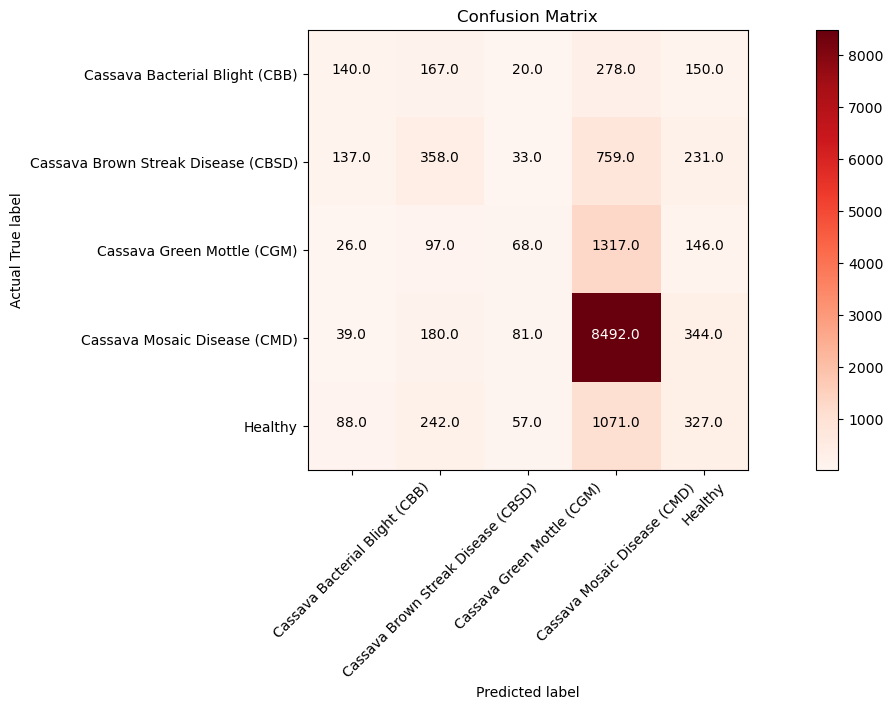

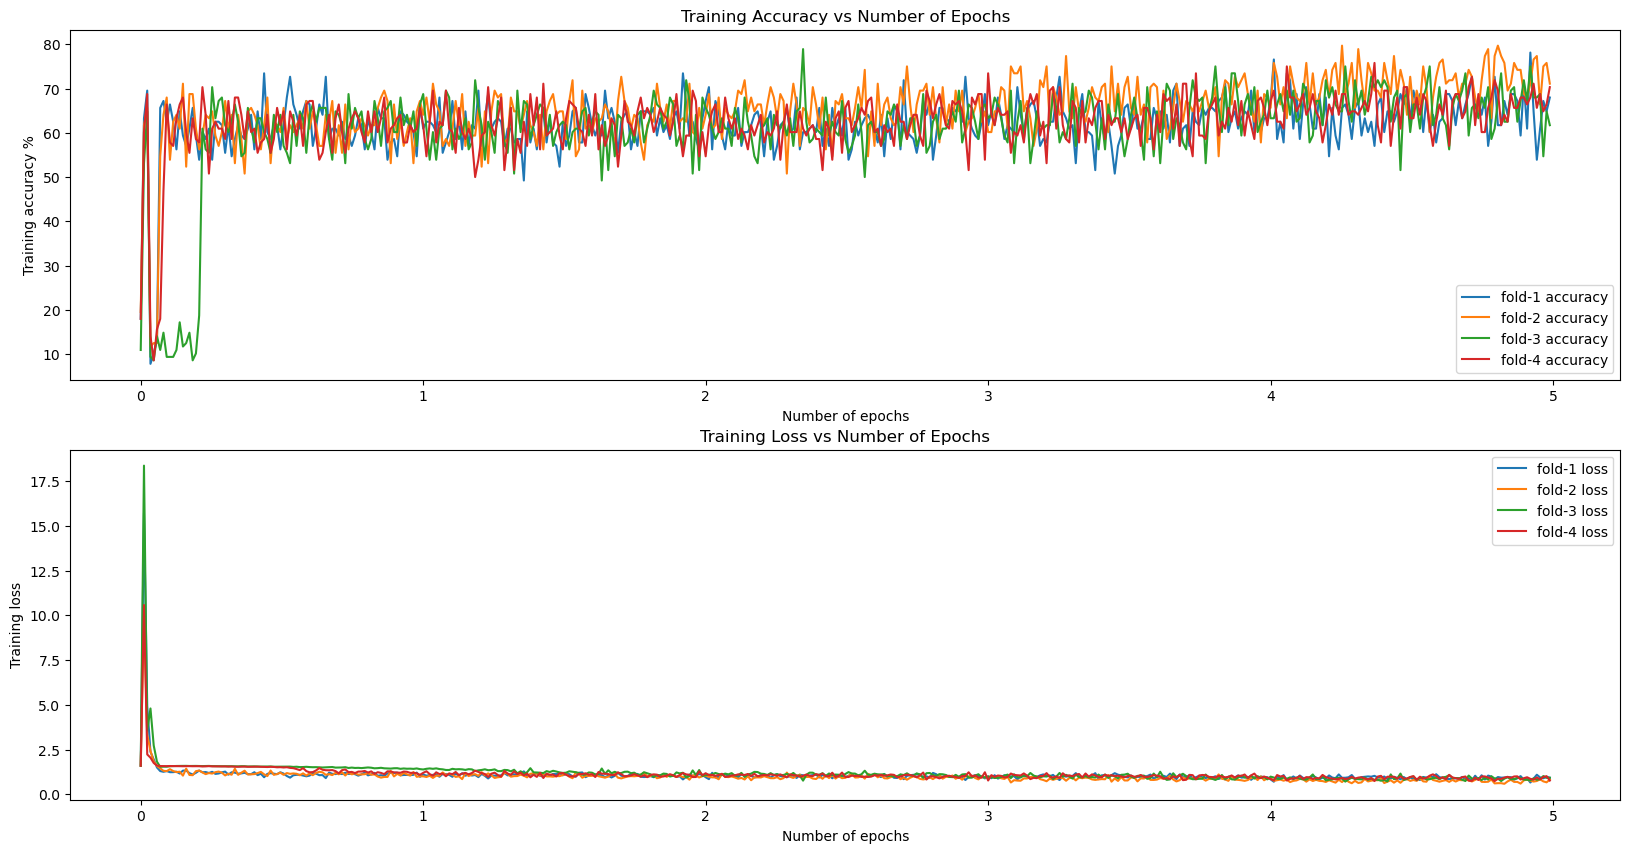

In [23]:
# plot the confusion matrix and the training metrics
conf_mat = np.array(total_confusion_matrix)

plot_cm(conf_mat, CLASSES)
plot_training_metrics(epoch_metrics_df)

-- TEST SET METRICS --
Accuracy: 59.594%
F-score: 0.293
Recall: 0.352
Precision: 0.302


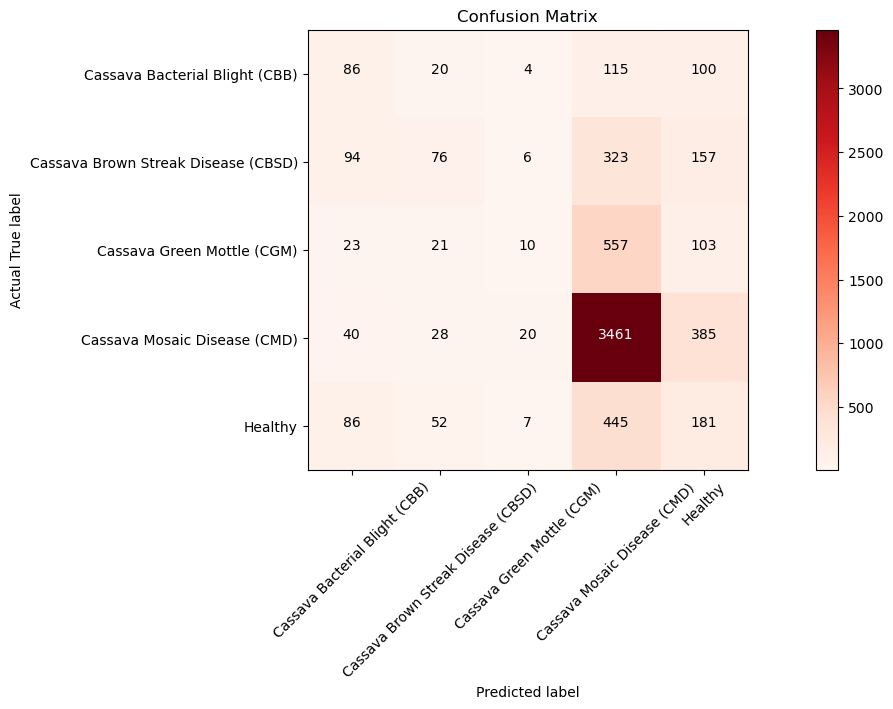

In [25]:
test_model(CustomCNN(), device, testset_loader )